In [116]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import html2text

from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import Imputer
from collections import Counter

%matplotlib inline

<p>First, I load the data into a pandas Dataframe. I also determine the labels for the data. For this analysis, any account type that has a label beginning with "frauds" will be considered fraud.</p>

In [117]:
data = pd.read_json('train_new.json')

# Get labels for data
def get_acct_type(row):
    return row.startswith('frauds') * 1


data['acct_type'] = data['acct_type'].apply(get_acct_type)

<p>Now, I split the dataframe into features (X) and labels (y) and perform a train-test split using scikit-learn. Then I put the labels back onto the training set to perform exploratory data analysis (EDA).</p>

In [118]:
y = data.pop('acct_type')
X = data

X_train, X_test, y_train, y_test = train_test_split(X, y)
# Put training data back together for EDA
X_train['acct_type'] = y_train

<p>Several columns have missing values, so I will deal with that as I get to each column.</p>

<p>The first feature I will explore is 'gts'. This data did not come with a README, so it is unclear what this feature is. The values do not appear to be timestamps or prices. They are all integers.</p>

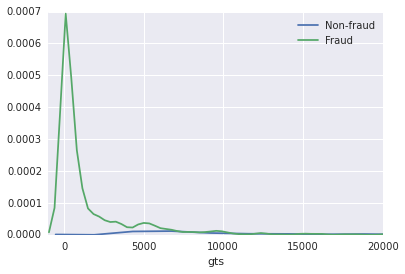

In [119]:
sns.distplot(X_train[X_train['acct_type'] == 0]['gts'], hist=False, kde=True, label='Non-fraud')
sns.distplot(X_train[X_train['acct_type'] == 1]['gts'], hist=False, kde=True, label='Fraud')
plt.axis([-1000, 20000, 0, 0.0007])
plt.legend()

<p>As shown by the kernel density estimation (kde) above, the fraudulent events seem to have a higher proportion of low gts values. (The x-axis was truncated, as this is the area that is most interesting.)</p>  

<p>Now I will look at the quantity of tickets sold for each event. I will first have to calculate the total, since this column contains lists of dictionaries.</p>

In [120]:
# Sum number of tickets sold for event
def get_tix_sold(row):
    sold = 0
    for ix in row:
        sold += ix['quantity_sold']
    return sold


# Total number of tickets available
def get_tix_avail(row):
    available = 0
    for ix in row:
        available += ix['quantity_total']
    return available


# Whether too many tickets were sold (quantity sold > total for sale)
def too_many_tix(row):
    sold_too_many = 0
    for ix in row:
        if (ix['quantity_sold'] > ix['quantity_total']):
            sold_too_many = 1
    return sold_too_many
    

X_train['quantity_sold'] = X_train['ticket_types'].apply(get_tix_sold)
X_train['quant_avail'] = X_train['ticket_types'].apply(get_tix_avail)
X_train['sold_too_many'] = X_train['ticket_types'].apply(too_many_tix)

In [121]:
print "If events oversold tickets (mean):"
print "fraud:", X_train[X_train['acct_type'] == 1]['sold_too_many'].mean()
print "not fraud:", X_train[X_train['acct_type'] == 0]['sold_too_many'].mean()

If events oversold tickets (mean):
fraud: 0.0030959752322
not fraud: 0.0536645200859


Fraudulent events appear to oversell their tickets at a much lower rate than the non-fraud events.

In [122]:
print "Mean quantity of tickets available:"
print "fraud:", X_train[X_train['acct_type'] == 1]['quant_avail'].mean()
print "not fraud:", X_train[X_train['acct_type'] == 0]['quant_avail'].mean()

Mean quantity of tickets available:
fraud: 42744.9195046
not fraud: 2059.98384953


<p>It appears that fraudulent events, on average, offer significantly more tickets for sale than non-fraudulent events.</p><p>Now, I will look at previous payouts. This column also contains lists of dictionaries. I will extract the length of this list (number of previous payouts) as a feature.</p>

In [123]:
def prev_payout(row):
    return len(row)


X_train['previous_payouts'] = X_train['previous_payouts'].apply(prev_payout)

In [124]:
print "Mean number of previous payouts:"
print "fraud:", X_train[X_train['acct_type'] == 1]['previous_payouts'].mean()
print "not fraud:", X_train[X_train['acct_type'] == 0]['previous_payouts'].mean()

Mean number of previous payouts:
fraud: 1.782249742
not fraud: 84.75191659


<p>It is clear from the above averages that fraudulent accounts have much fewer previous payouts, on average, than non-fraud accounts. This has the potential to be a useful feature.</p>

<p>Now, I will look at the difference between the 'event_start' and 'user_created' timestamps to see if it seems significant for determining whether an event is fraudulent or not.<p> 

In [125]:
X_train['time_diff'] = X_train['event_start'] - X_train['user_created']

In [126]:
print "Time difference:"
print "fraud:", X_train[X_train['acct_type'] == 1]['time_diff'].mean()
print "not fraud:", X_train[X_train['acct_type'] == 0]['time_diff'].mean()

Time difference:
fraud: 8951889.62229
not fraud: 39599356.7979


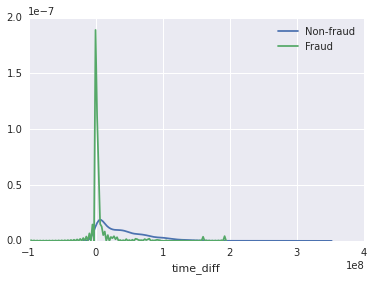

In [127]:
sns.distplot(X_train[X_train['acct_type'] == 0]['time_diff'], hist=False,
             kde=True, label='Non-fraud')
sns.distplot(X_train[X_train['acct_type'] == 1]['time_diff'], hist=False,
             kde=True, label='Fraud')
plt.legend()

<p>It appears that fraud accounts tend to have a short amount of time between when the user created the event and when the event starts. The average time difference is higher for non-fraudulent events than fraudulent events. This appears to be significant.</p>

<p>---</p>
<p>Now, I will look at email domains. For this, I will use Laplace smoothing to determine the probability of fraud for each email domain. To do this, I will use the following equation:</p>

$$p_{fraud}=\frac{n_{fraud} + 1}{n_{total} + 2}$$

<p>where <i>p_fraud</i> is the probability of fraud for a given email domain, <i>n_fraud</i> is the number of fraudulent accounts associated with the domain, and <i>n_total</i> is the total number of accounts with the email domain in the training set. <i>p_fraud</i> can be thought of as a Bayesian prior for each email domain. This makes more intuitive sense than calculating the absolute probabilities. i.e.: $$p_{fraud}=\frac{n_{fraud}}{n_{total}}$$ This way, if there are zero instances of fraud in the training set for one email domain, we don't assume that the probability of there ever being a fraudulent account associated with the domain is 0. Likewise, if 100% of the events in the training set associated with a certain domain are fraudulent, it is not reasonable to assume with 100% certainty that all future events from the email domain will be fraudulent.</p>

In [128]:
domain_counts_total = Counter(X_train['email_domain'].values)
domain_counts_fraud = Counter(X_train[X_train['acct_type'] == 1]['email_domain'].values)

p_fraud_emails = {}

for domain in domain_counts_total:
    fraud_count = domain_counts_fraud.get(domain, 0)
    total_count = domain_counts_total[domain]
    p_fraud_emails[domain] = (fraud_count + 1) / float(total_count + 2)


In [129]:
def get_email_fraud_prob(row, domain_probs=p_fraud_emails):
    # If no info about email domain, return 0.5
    # (50% chance it is associated with fraud)
    return domain_probs.get(row, 0.5)

X_train['email_probs'] = X_train['email_domain'].apply(get_email_fraud_prob)

In [130]:
print "Rates of fraud (higher values indicate more fraud):"
print "\tlatitude:"
print "\t\tnot-null: ", X_train[X_train['venue_latitude'].notnull()]['acct_type'].mean()
print "\t\tnull: ", X_train[X_train['venue_latitude'].isnull()]['acct_type'].mean()

print "\tlongitude:"
print "\t\tnot-null: ", X_train[X_train['venue_longitude'].notnull()]['acct_type'].mean()
print "\t\tnull: ", X_train[X_train['venue_longitude'].isnull()]['acct_type'].mean()

Rates of fraud (higher values indicate more fraud):
	latitude:
		not-null:  0.0692740800322
		null:  0.347394540943
	longitude:
		not-null:  0.0692740800322
		null:  0.347394540943


The rate of fraud is significantly higher for entries that have null values for venue latitude and longitude. I will create a column that indicates whether the latitude and longitude were missing from each row. Then, I will fill the missing latitude and longitude values with the mean latitude and longitude. This will allow the ensemble algorithms to separate samples based on whether or not the geographic data was missing.

In [131]:
X_train['missing_geographic_data'] = X_train['venue_latitude'].isnull().astype(int)

imputer = Imputer()
X_train[['venue_latitude', 'venue_longitude']] = imputer.fit_transform(X_train[['venue_latitude',
                                                                                'venue_longitude']])

Now, I want to analyze the event descriptions. The descriptions are written in html, so I need to extract the text from the tags. I will use html2text for this purpose.

In [132]:
def get_text(row):
    h = html2text.HTML2Text()
    h.ignore_links = True
    return h.handle(row)

X_train['description'] = X_train['description'].apply(get_text)

Next, I need to transform the raw text into feature vectors for training the classifier. I use the tf-idf vectorizer from sklearn. This will create feature vectors for the text, which essentially gives a weighted frequency of each word in each text sample (<a href="http://nlp.stanford.edu/IR-book/html/htmledition/tf-idf-weighting-1.html">Stanford</a>). I also want to remove stopwords (such as "if", "the", etc.), as these are very common and not useful for the analysis. I include an n-gram range of 1-2, which means the vectorizer will consider all of the words alone, but will also consider pairs of words.

In [133]:
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2))
X_nb = vectorizer.fit_transform(X_train['description'])
y_nb = X_train['acct_type']

I will use a Multinomial Naive Bayes algorithm for the text classification. 

In [134]:
nb = MultinomialNB()
nb.fit(X_nb, y_nb)
# Use fitted model to get prob. of fraud based on event descriptions
X_train['text_prob'] = nb.predict_proba(X_nb)[:, 1]

In [135]:
print "Mean body length:"
print "fraud:", X_train[X_train['acct_type'] == 1]['body_length'].mean()
print "not fraud:", X_train[X_train['acct_type'] == 0]['body_length'].mean()

Mean body length:
fraud: 1557.33539732
not fraud: 3911.41735664


As shown above, the fraudulent submissions have a significantly lower average body length than the non-fraudulent submissions.

<p>---</p>
Lastly, I will convert the "listed" column from 'n' or 'y' to 0 or 1.

In [136]:
def convert_listed_col(row):
    if row == 'y':
        return 1
    elif row == 'n':
        return 0

X_train['listed'] = X_train['listed'].apply(convert_listed_col)

Now, I will prepare the training and test sets for the model building. I need to only keep the columns I need for the analysis in the training set, and I need to perform the same feature engineering on the test set.

In [137]:
X_train = X_train[['body_length', 'channels', 'delivery_method', 'fb_published', 'gts', 'has_analytics',
                   'has_header', 'has_logo', 'listed', 'name_length', 'num_order', 'num_payouts', 'previous_payouts',
                   'sale_duration', 'sale_duration2', 'show_map', 'user_age', 'user_type', 'venue_latitude',
                   'venue_longitude', 'missing_geographic_data', 'quantity_sold', 'quant_avail', 'sold_too_many',
                   'time_diff', 'text_prob', 'email_probs']]

In [138]:
X_test['quantity_sold'] = X_test['ticket_types'].apply(get_tix_sold)
X_test['quant_avail'] = X_test['ticket_types'].apply(get_tix_avail)
X_test['sold_too_many'] = X_test['ticket_types'].apply(too_many_tix)

In [139]:
X_test['previous_payouts'] = X_test['previous_payouts'].apply(prev_payout)
X_test['time_diff'] = X_test['event_start'] - X_test['user_created']
X_test['email_probs'] = X_test['email_domain'].apply(get_email_fraud_prob)
X_test['description'] = X_test['description'].apply(get_text)
X_test['listed'] = X_test['listed'].apply(convert_listed_col)
X_test['missing_geographic_data'] = X_test['venue_latitude'].isnull().astype(int)
X_test[['venue_latitude', 'venue_longitude']] = imputer.transform(X_test[['venue_latitude', 'venue_longitude']])

In [140]:
X_nb_test = vectorizer.transform(X_test['description'])
X_test['text_prob'] = nb.predict_proba(X_nb_test)[:, 1]

In [141]:
X_test = X_test[['body_length', 'channels', 'delivery_method', 'fb_published', 'gts', 'has_analytics',
                 'has_header', 'has_logo', 'listed', 'name_length', 'num_order', 'num_payouts', 'previous_payouts',
                 'sale_duration', 'sale_duration2', 'show_map', 'user_age', 'user_type', 'venue_latitude',
                 'venue_longitude', 'missing_geographic_data', 'quantity_sold', 'quant_avail', 'sold_too_many',
                 'time_diff', 'text_prob', 'email_probs']]

In [144]:
X_train = X_train.fillna(-1)
X_test = X_test.fillna(-1)

First, I will try a random forest classifier with 1,000 estimators to see how it performs.

In [186]:
rf = RandomForestClassifier(n_estimators=1000, n_jobs=-1, class_weight='balanced')

In [146]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [147]:
rf.score(X_test, y_test)

0.98605299860529982

The score is quite good, but I want to take a look at the confusion matrix to get an idea of how well it is classifying each class type (fraud vs. not fraud).

In [177]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(y_test.unique()))
    plt.xticks(tick_marks, ['not fraud', 'fraud'])
    plt.yticks(tick_marks, ['not fraud', 'fraud'])
    plt.grid(b=False)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


cm = confusion_matrix(y_test, rf.predict(X_test))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

In [149]:
cm_normalized

array([[ 0.99540018,  0.00459982],
       [ 0.10802469,  0.89197531]])

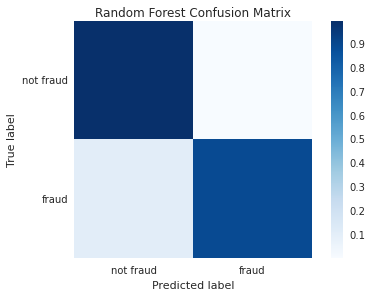

In [179]:
plot_confusion_matrix(cm_normalized, title='Random Forest Confusion Matrix')

The results using the random forest classifier are good.  We are getting about 98.6% accuracy overall, and a false positive rate of about 0.45%. The false negative rate is a bit higher than I would like, at about 10.8%. I want to also try an AdaBoost classifier, to see how it compares to the random forest model above.

In [180]:
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10),
                         algorithm='SAMME', n_estimators=1500)

In [181]:
ada.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=1.0, n_estimators=1500, random_state=None)

In [182]:
ada.score(X_test, y_test)

0.98800557880055784

In [183]:
cm_ada = confusion_matrix(y_test, ada.predict(X_test))
cm_ada_normalized = cm_ada.astype('float') / cm_ada.sum(axis=1)[:, np.newaxis]

In [184]:
cm_ada_normalized

array([[ 0.9966268 ,  0.0033732 ],
       [ 0.09876543,  0.90123457]])

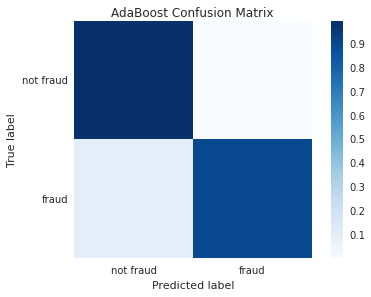

In [185]:
plot_confusion_matrix(cm_ada_normalized, title="AdaBoost Confusion Matrix")

The AdaBoost classifier appears to have done well, even slightly better than the random forest classifier. The accuracy is about 98.8%, and the false positive rate is about 0.34%. The false negative rate is around 9.9%. These numbers are all slight improvements over the random forest classifier. These values also indicate the AdaBoost classifier model is better at predicting both non-fraud and fraud events correctly.

<h2>Conclusion</h2>
<p>This is definitely a good start to building a classification model for detecting fraudulent event submissions. Based on a couple of models, we are getting high accuracy (~99%) overall, and a low false positive rate (~0.3%). The false negative rate could be significantly lower, so there is more that could be tried in an attempt to make this model better, such as: more/different feature engineering, different model types, and different parameters for the models.</p>